In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [71]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

In [72]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [73]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [74]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

In [75]:
earliest = session.query(Measurement.date).order_by(Measurement.date).first()
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print (earliest, latest)

('2010-01-01',) ('2017-08-23',)


Text(0.5, 0, 'Date')

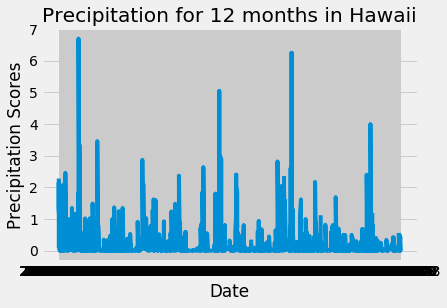

In [76]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp ).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp, columns=['date', 'precipitation'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df = prcp_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(prcp_df)
plt.title("Precipitation for 12 months in Hawaii" )
plt.ylabel("Precipitation Scores")
plt.xlabel("Date")


In [77]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [78]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).all()
station_count

[(9)]

In [79]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_data = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
station_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [80]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest = session.query(func.min(Measurement.tobs)).\
        filter(Measurement.station == 'USC00519281').all()
highest = session.query(func.max(Measurement.tobs)).\
        filter(Measurement.station == 'USC00519281').all()
average = session.query(func.avg(Measurement.tobs)).\
        filter(Measurement.station == 'USC00519281').all()

print(f'For USC00519281 Station, the lowest temperature is {lowest}, the hightest temperature is {highest}, and the average temperature is {average}.' )

For USC00519281 Station, the lowest temperature is [(54.0,)], the hightest temperature is [(85.0,)], and the average temperature is [(71.66378066378067,)].


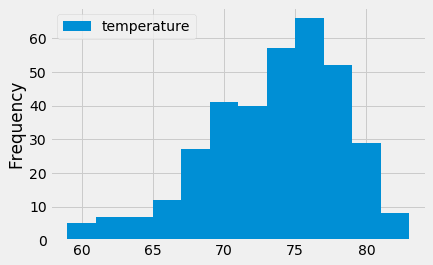

In [81]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

active_station = session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date > year_ago).all()

active_station_df = pd.DataFrame(active_station, columns = ['date', 'temperature'])

active_station_df.plot(kind='hist', bins=12)


## Bonus Challenge Assignment

In [82]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [84]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_date = '2015-03-15'
trip_year_ago = dt.date(2015,3,15) - dt.timedelta(days=365)
trip_temp = calc_temps(trip_year_ago, trip_date)
print(trip_temp)

[(56.0, 73.1641502129307, 85.0)]


In [100]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(1, height=trip_year_ago[0][1], trip_temp)
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.title('Trip Avg Temp')
plt.show()

SyntaxError: positional argument follows keyword argument (<ipython-input-100-15ea40c43e35>, line 6)

In [94]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

columns = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

result = session.query(*columns).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= trip_year_ago).\
    filter(Measurement.date <= trip_date).\
    group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()

result_df = pd.DataFrame(result, columns = columns)
result_df

,station.station,station.name,station.latitude,station.longitude,station.elevation,sum(measurement.prcp)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,127.05
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,82.17
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,52.38
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,38.38
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,37.93
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,17.65
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,16.60
7,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,3.13


In [95]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [96]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]

# Set the start and end date of the trip
trip_start_date = dt.date(2015,3,15)
trip_end_date = dt.date(2015,3,22)
# Use the start and end date to create a range of dates


# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [97]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [98]:
# Plot the daily normals as an area plot with `stacked=False`
